# Predicting Air Quality Index (AQI) in Montreal, QC

### Motivation
This notebook is best followed with the accompanying blog post https://tlbvr.com/blog/predicting-montreal-aqi but TL;DR I wanted to test myself and create a deep learning model to try and predict past AQI values in Montreal.

I've tried to split up this notebook into meaningful sections you can all run at once (or dig into each of them if you're interested!). At the end you'll find various random sections with further explorations (mainly testing ensembling).

Original author: Thomas Lefebvre <thmslbvr@gmail.com>

## Initial setup

Defining a bunch of helpers and constants.

In [184]:
# Imports for JupyterLite
%pip install -q ipywidgets

In [185]:
import pandas as pd
import os
from fastai.tabular.all import *
import matplotlib.pyplot as plt
import ipywidgets as widgets
import concurrent.futures
import urllib.request

FIRST_DAY = pd.Timestamp("2014-01-01")
LAST_DAY = pd.Timestamp("2024-06-01")

def filter_known_range(df):
  return df[(df['datetime'] >= FIRST_DAY) & (df['datetime'] < LAST_DAY)]

In [186]:
def get_aqi_csv(data):
    filename,url = data
    full_filename = f"aqi_{filename}"

    if not os.path.exists(full_filename):
        df = pd.read_csv(url)
        df.to_csv(full_filename, index=False)
    else:
        df = pd.read_csv(full_filename)
    return df

In [187]:
def get_weather_csv(url):
    station_id = url.split('&stationID=')[1].split('&')[0]
    year = url.split('&Year=')[1].split('&')[0]
    month = url.split('&Month=')[1].split('&')[0]
    filepath = f"weather_{station_id}-{year}-{month}.csv"
    if os.path.exists(filepath):
        return filepath
    try:
        with urllib.request.urlopen(url, timeout=30) as response, open(filepath, 'wb') as out_file:
            out_file.write(response.read())
        return filepath
    except Exception as e:
        print(f"Failed to download {url}: {str(e)}")
        return None


In [188]:
def plot_preds(df):
    dates = pd.date_range(start=df['datetime'].min(), end=df['datetime'].max(), freq='D')
    options = [(date.strftime(' %Y-%m-%d '), date) for date in dates]

    date_range_slider = widgets.SelectionRangeSlider(
        options=options,
        index=(0, len(options)-1),
        description='Select Date Range',
        orientation='horizontal',
        layout={'width': '500px'}
    )

    def update_plot(date_range):
        # Filter the DataFrame for the selected date range
        start_date, end_date = date_range
        mask = (df['datetime'] >= start_date) & (df['datetime'] <= end_date)
        filtered_df = df.loc[mask].set_index('datetime')

        # Plotting
        plt.figure(figsize=(10, 5))
        plt.plot(filtered_df['Actual'], label='Actual AQI', color='blue')
        plt.plot(filtered_df['Predicted'], label='Predicted AQI', color='red', alpha=0.6)
        plt.title('Comparison of Actual and Predicted AQI')
        plt.xlabel('Date')
        plt.ylabel('AQI Value')
        plt.legend()
        plt.grid(True)
        plt.show()

    # Connect the SelectionRangeSlider to the update_plot function
    widgets.interact(update_plot, date_range=date_range_slider)

In [189]:
def split_data(df):
  split_date_valid = pd.Timestamp('2022-01-01')
  split_date_test = pd.Timestamp('2023-05-01')

  train_idx = df['datetime'] < split_date_valid
  valid_idx = (df['datetime'] >= split_date_valid) & (df['datetime'] < split_date_test)
  test_idx = df['datetime'] >= split_date_test

  train_idxs = np.where(train_idx)[0].tolist()
  valid_idxs = np.where(valid_idx)[0].tolist()
  test_idxs = np.where(test_idx)[0].tolist()

  return (train_idxs, valid_idxs, test_idxs)

In [190]:
def mk_analysis_df(df, preds, max):
  # Create DataFrame
  _df = pd.DataFrame({
      'datetime': df['datetime'],
      'Actual': df['valeur'] * max,
      'Predicted': preds.flatten() * max,
  })

  _df['Error'] = abs((_df['Actual'] - _df['Predicted']) / _df['Actual']) * 100


  return _df

def mk_dls(df):
  cont,cat = cont_cat_split(df, max_card=20, dep_var='valeur')
  return TabularPandas(
    df,
    procs=[Categorify, Normalize],
    cat_names=cat,
    cont_names=cont,
    y_names=['valeur'],
    splits=(train_idxs, valid_idxs),
    y_block=RegressionBlock()
).dataloaders(bs=2048)


## Weather CSVs exploration

Downloading and pre-processing weather-related data.



In [191]:
station_ids = ["30165", "51157"]

years = range(FIRST_DAY.year, LAST_DAY.year + 1)
months = range(1, 13)

dates = [(station_id, month, year) for year in years for month in months for station_id in station_ids]
urls = list(map(lambda xy: f"https://climate.weather.gc.ca/climate_data/bulk_data_e.html?format=csv&stationID={xy[0]}&Year={xy[2]}&Month={xy[1]}&Day=1&timeframe=1&submit=Download+Data", dates))
all_files = []

with concurrent.futures.ThreadPoolExecutor(max_workers=5) as executor:
    future_to_url = {executor.submit(get_weather_csv, url): url for url in urls}
    for future in concurrent.futures.as_completed(future_to_url):
        url = future_to_url[future]
        try:
            filepath = future.result()
            all_files.append(pd.read_csv(filepath))
        except Exception as exc:
            print('%r generated an exception: %s' % (url, exc))

weather_df = pd.concat(all_files)
weather_df.rename(columns={'Date/Time (LST)': 'datetime',
                           "Temp (°C)": "temp",
                           "Precip. Amount (mm)":
                           "precip", "Rel Hum (%)": "rel_humid",
                           "Weather": "weather",
                           "Wind Chill": "wind_chill",
                           "Stn Press (kPa)": "pressure",
                           "Visibility (km)": "visibility"}, inplace=True)
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])
weather_df


,Longitude (x),Latitude (y),Station Name,Climate ID,datetime,Year,Month,Day,Time (LST),temp,...,Wind Spd Flag,visibility,Visibility Flag,pressure,Stn Press Flag,Hmdx,Hmdx Flag,wind_chill,Wind Chill Flag,weather
0,-73.74,45.47,MONTREAL/PIERRE ELLIOTT TRUDEAU INTL,702S006,2014-02-01 00:00:00,2014,2,1,00:00,-4.8,...,NaN,NaN,NaN,101.70,NaN,NaN,NaN,-8.0,NaN,NaN
1,-73.74,45.47,MONTREAL/PIERRE ELLIOTT TRUDEAU INTL,702S006,2014-02-01 01:00:00,2014,2,1,01:00,-5.4,...,NaN,NaN,NaN,101.81,NaN,NaN,NaN,-9.0,NaN,NaN
2,-73.74,45.47,MONTREAL/PIERRE ELLIOTT TRUDEAU INTL,702S006,2014-02-01 02:00:00,2014,2,1,02:00,-5.7,...,NaN,NaN,NaN,101.82,NaN,NaN,NaN,-9.0,NaN,NaN
3,-73.74,45.47,MONTREAL/PIERRE ELLIOTT TRUDEAU INTL,702S006,2014-02-01 03:00:00,2014,2,1,03:00,-6.2,...,NaN,NaN,NaN,101.92,NaN,NaN,NaN,-10.0,NaN,NaN
4,-73.74,45.47,MONTREAL/PIERRE ELLIOTT TRUDEAU INTL,702S006,2014-02-01 04:00:00,2014,2,1,04:00,-7.3,...,NaN,NaN,NaN,101.96,NaN,NaN,NaN,-10.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
739,-73.74,45.47,MONTREAL INTL A,7025251,2022-08-31 19:00:00,2022,8,31,19:00,19.5,...,NaN,19.3,NaN,100.09,NaN,NaN,NaN,NaN,NaN,Rain Showers
740,-73.74,45.47,MONTREAL INTL A,7025251,2022-08-31 20:00:00,2022,8,31,20:00,17.6,...,NaN,24.1,NaN,100.04,NaN,NaN,NaN,NaN,NaN,NaN
741,-73.74,45.47,MONTREAL INTL A,7025251,2022-08-31 21:00:00,2022,8,31,21:00,17.0,...,NaN,24.1,NaN,100.08,NaN,NaN,NaN,NaN,NaN,NaN
742,-73.74,45.47,MONTREAL INTL A,7025251,2022-08-31 22:00:00,2022,8,31,22:00,16.1,...,NaN,24.1,NaN,100.05,NaN,NaN,NaN,NaN,NaN,Cloudy


In [192]:
# Some stations only include a subset of the data in each field...
weather_station_df1 = weather_df[weather_df['Station Name'] == 'MONTREAL/PIERRE ELLIOTT TRUDEAU INTL'][['datetime', 'temp', 'precip', 'rel_humid']]
weather_station_df2 = weather_df[weather_df['Station Name'] == 'MONTREAL INTL A'][['datetime', 'weather', 'wind_chill', 'pressure', 'visibility']]

weather_df = pd.merge(weather_station_df1, weather_station_df2, on='datetime')
weather_df = filter_known_range(weather_df)

weather_df

,datetime,temp,precip,rel_humid,weather,wind_chill,pressure,visibility
0,2014-02-01 00:00:00,-4.8,0.0,65.0,NaN,-10.0,101.67,24.1
1,2014-02-01 01:00:00,-5.4,0.0,65.0,Mainly Clear,-12.0,101.78,24.1
2,2014-02-01 02:00:00,-5.7,0.0,65.0,NaN,-12.0,101.78,24.1
3,2014-02-01 03:00:00,-6.2,0.0,69.0,NaN,-14.0,101.89,24.1
4,2014-02-01 04:00:00,-7.3,0.0,75.0,Clear,-14.0,101.92,24.1
...,...,...,...,...,...,...,...,...
96427,2022-08-31 19:00:00,19.7,0.0,60.0,Rain Showers,NaN,100.09,19.3
96428,2022-08-31 20:00:00,17.9,0.0,77.0,NaN,NaN,100.04,24.1
96429,2022-08-31 21:00:00,17.4,0.0,76.0,NaN,NaN,100.08,24.1
96430,2022-08-31 22:00:00,16.7,0.0,81.0,Cloudy,NaN,100.05,24.1


In [193]:
weather_df.fillna({"precip": 0,
                   "temp": weather_df['temp'].fillna(method='bfill'),
                   "rel_humid": weather_df['rel_humid'].mode()[0],
                   "wind_chill": weather_df['wind_chill'].mode()[0],
                   "pressure": weather_df['pressure'].mode()[0],
                   "visibility": weather_df['visibility'].mode()[0],
                   "weather": weather_df['weather'].mode()[0]}, inplace=True)

weather_df.sort_values("datetime", inplace=True)

assert weather_df[weather_df.isna().any(axis=1)].empty == True

weather_df

,datetime,temp,precip,rel_humid,weather,wind_chill,pressure,visibility
2136,2014-01-01 00:00:00,-18.7,0.0,81.0,Mostly Cloudy,-25.0,101.63,24.1
2137,2014-01-01 01:00:00,-18.1,0.0,81.0,Mostly Cloudy,-27.0,101.69,24.1
2138,2014-01-01 02:00:00,-17.6,0.0,82.0,Mostly Cloudy,-25.0,101.79,24.1
2139,2014-01-01 03:00:00,-16.6,0.0,81.0,Mostly Cloudy,-24.0,101.84,24.1
2140,2014-01-01 04:00:00,-16.3,0.0,81.0,Cloudy,-22.0,101.88,24.1
...,...,...,...,...,...,...,...,...
89131,2024-05-31 19:00:00,22.4,0.0,27.0,Mainly Clear,-7.0,101.26,48.3
89132,2024-05-31 20:00:00,21.2,0.0,33.0,Mostly Cloudy,-7.0,101.30,48.3
89133,2024-05-31 21:00:00,20.2,0.0,36.0,Mostly Cloudy,-7.0,101.34,24.1
89134,2024-05-31 22:00:00,19.1,0.0,41.0,Clear,-7.0,101.41,24.1


<Axes: >

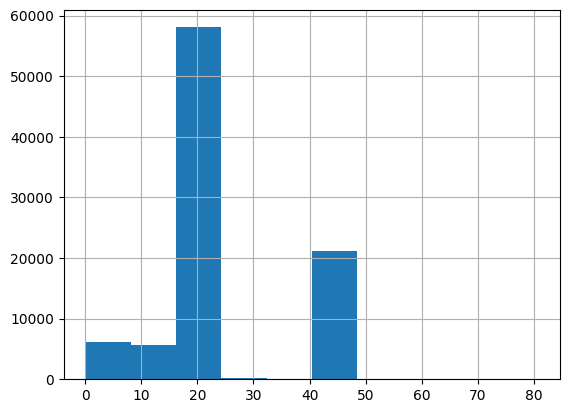

In [194]:
weather_df['visibility'].hist()

<Axes: >

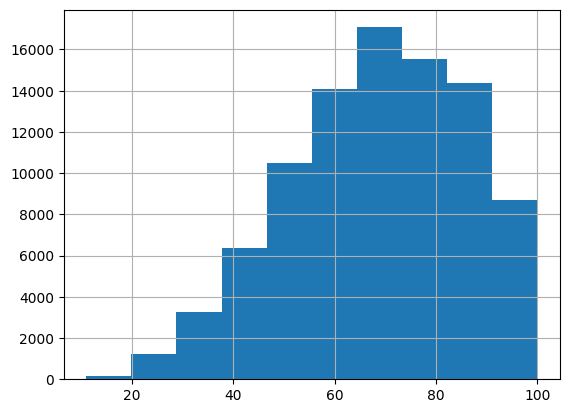

In [195]:
weather_df['rel_humid'].hist()

## AQI CSVs exploration

Downloading and pre-processing past AQI data.

In [196]:
files = [
    ('2022-2024.csv', 'https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/0c325562-e742-4e8e-8c36-971f3c9e58cd/download/rsqa-indice-qualite-air-2022-2024.csv'),
    ('2019-2021.csv', 'https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/e43dc1d6-fbdd-49c3-a79f-83f63404c281/download/rsqa-indice-qualite-air-2019-2021.csv'),
    ('2016-2018.csv', 'https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/93a3a88e-97ab-4ab1-813f-5419a1dd330d/download/rsqa-indice-qualite-air-2016-2018.csv'),
    ('2013-2015.csv', 'https://donnees.montreal.ca/dataset/547b8052-1710-4d69-8760-beaa3aa35ec6/resource/02cfaf0c-3b46-4dac-bf66-acd2ff47361a/download/rsqa-indice-qualite-air-2013-2015.csv')
]

all_files = []

with concurrent.futures.ThreadPoolExecutor() as executor:
    all_files = executor.map(get_aqi_csv, files)

In [197]:
df = pd.concat(all_files)
df['datetime'] = pd.to_datetime(df['date'] + ' ' + df['heure'].astype(str) + ':00:00',
                                format = '%Y-%m-%d %H:%M:%S',
                                errors = 'coerce')
df.drop(["heure", "polluant", "date"], axis=1, inplace=True)
df.sort_values("datetime", inplace=True)

df = filter_known_range(df)

assert df[df.isna().any(axis=1)].empty == True
df

,stationId,valeur,datetime
313464,66,7,2014-01-01 00:00:00
313462,66,1,2014-01-01 00:00:00
363110,3,1,2014-01-01 00:00:00
331116,55,1,2014-01-01 00:00:00
331118,55,5,2014-01-01 00:00:00
...,...,...,...
761449,6,4,2024-05-31 23:00:00
761448,6,11,2024-05-31 23:00:00
761447,6,1,2024-05-31 23:00:00
759354,3,1,2024-05-31 23:00:00


In [198]:
group1_df = df.groupby(['stationId', 'datetime']).max("valeur")
group1_df

valeur
stationId datetime                   
3         2014-01-01 00:00:00      24
          2014-01-01 01:00:00      26
          2014-01-01 02:00:00      26
          2014-01-01 03:00:00      25
          2014-01-01 04:00:00      26
...                               ...
103       2024-05-31 19:00:00      24
          2024-05-31 20:00:00      19
          2024-05-31 21:00:00      12
          2024-05-31 22:00:00      12
          2024-05-31 23:00:00      16

[978280 rows x 1 columns]

In [199]:
group2_df = group1_df.groupby("datetime").mean("valeur")
group2_df.reset_index(inplace=True)

## Feature engineering

Adding a couple of more features and normalizing some others.

In [200]:
merged = pd.merge(group2_df, weather_df, on="datetime", how="left")

merged['year'] = merged['datetime'].dt.year
merged['month'] = merged['datetime'].dt.month
merged['day'] = merged['datetime'].dt.day
merged['weekday'] = merged['datetime'].dt.weekday
merged['hour'] = merged['datetime'].dt.hour

# TODO: not clamping result in a lower loss but weirdly worse predictions. Perhaps the model doesn't generalize as good?
merged['valeur'] = merged['valeur'].clip(upper=100)
max_value = merged['valeur'].max()
merged['valeur'] = merged['valeur'] / max_value

merged

,datetime,valeur,temp,precip,rel_humid,weather,wind_chill,pressure,visibility,year,month,day,weekday,hour
0,2014-01-01 00:00:00,0.227273,-18.7,0.0,81.0,Mostly Cloudy,-25.0,101.63,24.1,2014,1,1,2,0
1,2014-01-01 01:00:00,0.247273,-18.1,0.0,81.0,Mostly Cloudy,-27.0,101.69,24.1,2014,1,1,2,1
2,2014-01-01 02:00:00,0.258182,-17.6,0.0,82.0,Mostly Cloudy,-25.0,101.79,24.1,2014,1,1,2,2
3,2014-01-01 03:00:00,0.256364,-16.6,0.0,81.0,Mostly Cloudy,-24.0,101.84,24.1,2014,1,1,2,3
4,2014-01-01 04:00:00,0.250909,-16.3,0.0,81.0,Cloudy,-22.0,101.88,24.1,2014,1,1,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91291,2024-05-31 19:00:00,0.228182,22.4,0.0,27.0,Mainly Clear,-7.0,101.26,48.3,2024,5,31,4,19
91292,2024-05-31 20:00:00,0.194545,21.2,0.0,33.0,Mostly Cloudy,-7.0,101.30,48.3,2024,5,31,4,20
91293,2024-05-31 21:00:00,0.152727,20.2,0.0,36.0,Mostly Cloudy,-7.0,101.34,24.1,2024,5,31,4,21
91294,2024-05-31 22:00:00,0.150909,19.1,0.0,41.0,Clear,-7.0,101.41,24.1,2024,5,31,4,22


## Training

Get data ready for the neural network and fire off training.

In [201]:
(train_idxs, valid_idxs, test_idxs) = split_data(merged)

train_valid_df = pd.concat([
    merged.loc[train_idxs],
    merged.loc[valid_idxs],
])

train_valid_df

,datetime,valeur,temp,precip,rel_humid,weather,wind_chill,pressure,visibility,year,month,day,weekday,hour
0,2014-01-01 00:00:00,0.227273,-18.7,0.0,81.0,Mostly Cloudy,-25.0,101.63,24.1,2014,1,1,2,0
1,2014-01-01 01:00:00,0.247273,-18.1,0.0,81.0,Mostly Cloudy,-27.0,101.69,24.1,2014,1,1,2,1
2,2014-01-01 02:00:00,0.258182,-17.6,0.0,82.0,Mostly Cloudy,-25.0,101.79,24.1,2014,1,1,2,2
3,2014-01-01 03:00:00,0.256364,-16.6,0.0,81.0,Mostly Cloudy,-24.0,101.84,24.1,2014,1,1,2,3
4,2014-01-01 04:00:00,0.250909,-16.3,0.0,81.0,Cloudy,-22.0,101.88,24.1,2014,1,1,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81763,2023-04-30 19:00:00,0.200000,11.5,1.4,77.0,Cloudy,-7.0,99.42,24.1,2023,4,30,6,19
81764,2023-04-30 20:00:00,0.200000,10.8,0.2,81.0,Rain,-7.0,99.29,12.9,2023,4,30,6,20
81765,2023-04-30 21:00:00,0.207273,10.3,1.1,81.0,Mostly Cloudy,-7.0,99.12,24.1,2023,4,30,6,21
81766,2023-04-30 22:00:00,0.204545,11.0,0.0,73.0,Cloudy,-7.0,98.92,24.1,2023,4,30,6,22


In [202]:
dls = mk_dls(train_valid_df)

dls.show_batch()

,datetime,weather,year,month,weekday,temp,precip,rel_humid,wind_chill,pressure,visibility,day,hour,valeur
0,2014-01-26 23:00:00,Snow,2014,1,6,-14.400000,1.277778e-09,76.000000,-23.0,100.070000,9.699999,26.0,23.0,0.174545
1,2016-12-07 09:00:00,"Drizzle,Fog",2016,12,2,0.200000,1.277778e-09,97.999999,-3.0,100.699997,2.000000,7.0,9.0,0.182727
2,2015-12-01 04:00:00,Clear,2015,12,1,-4.600000,1.277778e-09,81.000000,-7.0,102.300003,24.100000,1.0,4.0,0.233333
3,2018-04-10 01:00:00,Mainly Clear,2018,4,1,-1.900000,1.277778e-09,65.000000,-7.0,101.750000,24.100000,10.0,1.0,0.160909
4,2015-04-17 17:00:00,Mostly Cloudy,2015,4,4,17.800000,1.277778e-09,45.999999,-7.0,100.459999,48.299999,17.0,17.0,0.262000
5,2015-04-25 06:00:00,Mostly Cloudy,2015,4,5,1.400000,1.277778e-09,66.000000,-7.0,100.580002,24.100000,25.0,6.0,0.093000
6,2018-02-16 22:00:00,Clear,2018,2,4,-7.599999,1.277778e-09,54.000000,-13.0,101.620003,24.100000,16.0,22.0,0.177273
7,2018-08-21 21:00:00,Mostly Cloudy,2018,8,1,23.500000,1.277778e-09,65.000000,-7.0,100.430000,24.100000,21.0,21.0,0.146364
8,2020-05-06 12:00:00,Mostly Cloudy,2020,5,2,12.300000,1.277778e-09,35.000000,-7.0,100.790001,48.299999,6.0,12.0,0.184545
9,2014-09-13 10:00:00,Cloudy,2014,9,5,10.300000,1.277778e-09,74.000000,-7.0,101.830002,24.100000,13.0,10.0,0.114545


I've noticed that reducing the number of activations on the last layer helps

In [203]:
hidden=[250,100]

SuggestedLRs(valley=0.0002290867705596611, slide=0.007585775572806597)

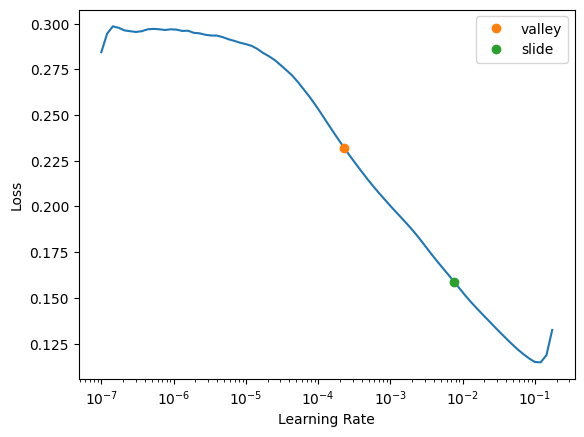

In [179]:
tabular_learner(dls, metrics=mae, layers=hidden).lr_find(suggest_funcs=[valley, slide])

In [204]:
learn = tabular_learner(dls, metrics=mae, layers=hidden, y_range=(0, 1))
learn.fit_one_cycle(10, 0.002)

epoch,train_loss,valid_loss,mae,time
0,0.118997,0.126913,0.352065,00:01
1,0.096815,0.059786,0.238778,00:01
2,0.051025,0.003853,0.049051,00:01
3,0.024402,0.002695,0.038271,00:01
4,0.012091,0.002645,0.036937,00:01
5,0.006113,0.002408,0.035103,00:01
6,0.003128,0.002503,0.036121,00:01
7,0.001622,0.002510,0.036289,00:01
8,0.000859,0.002485,0.035845,00:01
9,0.000472,0.002498,0.036033,00:01


In [205]:
df_test = merged.loc[test_idxs]
test_dl = dls.test_dl(df_test)

preds, targets = learn.get_preds(dl=test_dl)

mae(preds, targets)

TensorBase(0.0440)

In [206]:
analysis_df = mk_analysis_df(df_test, preds.flatten(), max_value)

In [207]:
plot_preds(analysis_df)

interactive(children=(SelectionRangeSlider(description='Select Date Range', index=(0, 396), layout=Layout(widt…

### Export

In [ ]:
export_df = analysis_df
export_df.set_index('datetime', inplace=True)
# Resample to remove a few data points, otherwise it's massive.
export_df = export_df.resample('4H').mean()
export_df.reset_index(inplace=True)
export_df.rename(columns={'datetime': 'date'}, inplace=True)

mean_error = export_df['Error'].mean()

json_output = export_df.to_json(orient='records', indent=2)
json_dict = json.loads(json_output)

# Create a new dictionary with the "results" property
result_dict = {"mean_error": mean_error, "results": json_dict}

# Convert dictionary to JSON string with indentation
final_json_str = json.dumps(result_dict, indent=4)

# Write the JSON output to a file
with open('aqi.json', 'w') as file:
    file.write(final_json_str)

## Ensembling explorations


In [124]:
hidden=[250, 100]
lr=0.002
epochs=10
(train_idxs, valid_idxs, test_idxs) = split_data(merged)

train_valid_df = pd.concat([
    merged.loc[train_idxs],
    merged.loc[valid_idxs],
])

dls = mk_dls(train_valid_df)

### Bagging

In [127]:
def train(n_models, train_df, train_idxs, valid_idxs, test_df):
  total_length = len(train_idxs)
  subset_size = int(total_length * 0.8)  # Each model trains on 80% of data
  # Determine the maximum start index for training to ensure full subset_size can be used
  max_start_idx = total_length - subset_size
  predictions = []

  # This will train sequentially but it's fine since we're not going to create many models
  for n in range(1, n_models + 1):
    # Calculate start index for each model to ensure time series order is maintained
    start_idx = (n * max_start_idx) // n_models
    end_idx = start_idx + subset_size
    # Generate contiguous subset of train_idxs
    model_train_idxs = train_idxs[start_idx:end_idx]

    to = mk_dls(train_df)

    learn = tabular_learner(to, metrics=mae, layers=[500, 250], y_range=(0, 1))

    with learn.no_logging(), learn.no_mbar():
      learn.fit_one_cycle(epochs, lr)

    test_dl = to.test_dl(test_df)
    preds, targets = learn.get_preds(dl=test_dl)
    predictions.append(preds)

  return (torch.stack(predictions).mean(dim=0), targets)

In [128]:
(all_preds, targets) = train(5, merged, train_idxs, valid_idxs, merged.loc[test_idxs])

In [129]:
mae(all_preds, targets)

TensorBase(0.0437)

In [130]:
analysis_df = mk_analysis_df(merged.loc[test_idxs], all_preds, max_value)
plot_preds(analysis_df)

interactive(children=(SelectionRangeSlider(description='Select Date Range', index=(0, 396), layout=Layout(widt…

### Random forests

_RandomForest doesn't seem to offer much better results than using deep learning for this dataset._

In [112]:
from sklearn.ensemble import RandomForestRegressor
import torch

m = RandomForestRegressor(n_jobs=-1, n_estimators=250,
        max_samples=10_000, max_features=0.5,
        min_samples_leaf=5, oob_score=True).fit(dls.train.xs, dls.train.y)
preds = m.predict(dls.valid.xs)
preds_tensor = torch.tensor(preds)

mae(preds_tensor, torch.tensor(dls.valid.y.values))

TensorBase(0.0399)

In [113]:
rf_df_test = merged.loc[test_idxs]
rf_test_dl = dls.test_dl(rf_df_test)

In [114]:
rf_preds = torch.tensor(m.predict(rf_test_dl.xs))
mae(rf_preds, torch.tensor(rf_test_dl.y.values))

TensorBase(0.0467)

In [115]:
rf_analysis_df = mk_analysis_df(rf_df_test, rf_preds, max_value)
rf_analysis_df

,datetime,Actual,Predicted,Error
81768,2023-05-01 00:00:00,20.000000,18.191663,9.041685
81769,2023-05-01 01:00:00,19.636364,17.961806,8.527842
81770,2023-05-01 02:00:00,19.909091,17.708982,11.050777
81771,2023-05-01 03:00:00,19.727273,17.426805,11.661356
81772,2023-05-01 04:00:00,19.700000,17.632985,10.492464
...,...,...,...,...
91291,2024-05-31 19:00:00,22.818182,23.812175,4.356146
91292,2024-05-31 20:00:00,19.454545,22.251929,14.379074
91293,2024-05-31 21:00:00,15.272727,21.003537,37.523156
91294,2024-05-31 22:00:00,15.090909,20.067686,32.978644


In [116]:
plot_preds(rf_analysis_df)

interactive(children=(SelectionRangeSlider(description='Select Date Range', index=(0, 396), layout=Layout(widt…

### Ensemble

In [131]:
def train(n_model, dls):
  all_preds = []
  for x in range(1, n_model + 1):
    learn = tabular_learner(dls, metrics=mae, layers=[500, 250], y_range=(0, 1))
    with learn.no_logging(), learn.no_mbar():
      learn.fit_one_cycle(epochs, lr)
    df_test = merged.loc[test_idxs]
    test_dl = dls.test_dl(df_test)
    preds, targets = learn.get_preds(dl=test_dl)
    print(mae(preds, targets))

    all_preds.append(preds)
  return (torch.stack(all_preds).mean(dim=0), targets)


In [132]:
(all_preds, targets) = train(5, dls)
mae(all_preds, targets)

TensorBase(0.0468)


TensorBase(0.0500)


TensorBase(0.0501)


TensorBase(0.0456)


TensorBase(0.0490)


TensorBase(0.0455)

In [134]:
analysis_df = mk_analysis_df(merged.loc[test_idxs], all_preds.flatten(), max_value)

plot_preds(analysis_df)

interactive(children=(SelectionRangeSlider(description='Select Date Range', index=(0, 396), layout=Layout(widt…

### LSTM Arch


##### Experimental

I have no idea what I just did and I don't think it actually works but I'm possibly not understanding how this thing operates. In theory LSTM architecture should help with time series data but I haven't done enough research on that.

In [135]:
n_steps = 24  # Number of time steps you look back

# This function creates sequences
def create_sequences(df, n_steps):
    features = ['valeur', 'temp', 'rel_humid', 'year', 'month', 'day', 'weekday', 'hour']
    X, y, times = [], [], []
    for i in range(n_steps, len(df)):
        # Create sliding windows
        times.append(df.iloc[i]['datetime'])  # Capture the datetime for each output sample

        without_date = df[features]
        X.append(without_date.iloc[i-n_steps:i].values)
        y.append(without_date.iloc[i]['valeur'])  # Assuming 'valeur' is the target to predict
    return np.array(X), np.array(y), np.array(times)

# Create sequences
X, y, times = create_sequences(merged, n_steps)

In [136]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15  # Ensure these add up to 1

# Calculate indices
train_idx = int(len(X) * train_ratio)
val_idx = train_idx + int(len(X) * val_ratio)

X_train, X_val, X_test = X[:train_idx], X[train_idx:val_idx], X[val_idx:]
y_train, y_val, y_test = y[:train_idx], y[train_idx:val_idx], y[val_idx:]
times_train, times_val, times_test = times[:train_idx], times[train_idx:val_idx], times[val_idx:]

In [137]:
from fastai.tabular.all import *
import torch
import torch.nn as nn

class LSTMModel(Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1, num_layers=1):
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Forward propagate LSTM
        x, _ = self.lstm(x)
        # Decode the hidden state of the last time step
        x = self.fc(x[:, -1, :])
        return x.squeeze(-1)

In [138]:
from torch.utils.data import TensorDataset

# Convert the training, validation, and test sets into PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDatasets
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

In [139]:
bs = 2048  # batch size
shuffle_train = False  # Typically you do not shuffle time series data

dls = DataLoaders.from_dsets(train_ds, val_ds, bs=bs, shuffle=shuffle_train, device='cuda')

In [140]:
input_dim = X_train.shape[2]  # Number of input features per timestep
hidden_dim = 50  # Number of features in the hidden state
output_dim = 1  # Predicting a single output
num_layers = 1  # Number of LSTM layers

model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)
learn = Learner(dls, model, loss_func=F.mse_loss, metrics=[mae])

# Train the model
learn.fit_one_cycle(epochs, lr)

epoch,train_loss,valid_loss,mae,time
0,0.019663,0.004511,0.047641,00:10
1,0.009537,0.004068,0.046951,00:04
2,0.006442,0.004081,0.047390,00:07
3,0.005166,0.004088,0.047546,00:04
4,0.004562,0.004095,0.047677,00:04
5,0.004256,0.004089,0.047558,00:06
6,0.004096,0.004068,0.046889,00:04
7,0.004002,0.004068,0.046812,00:04
8,0.003944,0.004068,0.046907,00:06
9,0.003912,0.004068,0.046941,00:04


This isn't training lol

In [144]:
test_dl = dls.test_dl(test_ds)
preds, targets = learn.get_preds(dl=test_dl)

mae(preds, targets)

TensorBase(0.0482)